# Chapter 5. 서포트 벡터 머신

> SVM (Support Vector Machine)

서포트 벡터머신은 매우 강력하고 선형이나 비선형 분류, 회귀, 이상치탐색에도 사용할 수 있는 다목적 머신러닝 모델입니다.

머신러닝에서 가장 인기있는 모델에 속하고 머신러닝에 관심있는 사람이라면 반드시! 알아야할 모델입니다. SVM은 특히 

- 복잡한 분류 문제에 잘 들어맞으며 
- 작거나 중간 크기의 데이터셋에 적합합니다.

이번 시간에는 SVM의 핵심 개념을 설명하고 사용 방법과 작동 원리를 살펴보도록 하겠습니다.

## 1. 선형 SVM 분류

![img](https://cdn.shortpixel.ai/client/q_glossy,ret_img,w_1372/http://hleecaster.com/wp-content/uploads/2020/01/svm01.png)

SVM 분류기는 **클래스 사이에 가장 폭이 넓은 도로를 찾는 것**이라고 생각할 수 있습니다. 그래서 *라지 마진 분류*(large margin classification)라고 합니다. 

도로 바깥쪽에 훈련 샘플을 더 추가해도 결정 경계에는 영향을 미치지 않습니다. 도로 경계에 위치한 샘플에 의해 전적으로 결정됩니다. 이런 샘플을 **서포트 벡터**라고 합니다.

SVM은 특성의 스케일에 민감하게 반응합니다. 특성의 스케일을 조정하면(예. 사이킷런의 `StandardScaler`를 사용하면) 결정 경계가 훨씬 좋아집니다.

### 1.1 소프트 마진 분류

모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있다면 이를 **하드 마진 분류**(hard margin classification)이라고 합니다.하드 마진 분류에는 두가지 문제점이 있습니다.

1. 데이터가 선형적으로 구분될 수 있어야 제대로 작동하며,
2. 이상치에 민감합니다.

![img](https://cdn.shortpixel.ai/client/q_glossy,ret_img,w_1280/http://hleecaster.com/wp-content/uploads/2020/01/svm06.png)

위 사진을 보시면 첫 번째 사진에서는 outlier로 존재하는 몇개의 값 때문에 일반화가 잘 된것 같지 않습니다.

이러한 문제를 피하려면 좀 더 유연한 모델이 필요합니다. 도로의 폭을 가능한 한 넓게 유지하는 것과 **마진 오류**(margin violation) 사이에 적절한 균형을 잡아야 합니다. 이를 **소프트 마진 분류**(soft margin classification)이라고 합니다.

사이킷런의 SVM 모델에서는 `C` 하이퍼 파라미터를 사용해 이 균형을 조절할 수 있습니다.

- `C` 값을 줄이면 도로의 폭이 넓어지지만 마진 오류도 줄어듭니다.
- `C` 값을 늘이면 마진 오류가 줄어들지만 도로의 폭이 줄어들게 됩니다.


붓꽃 데이터셋을 불러와 특성 스케일을 변경하고 선형 SVM 모델에 학습시킨 코드입니다. (C=1과 잠시후에 설명할 **힌지 손실**(hinge loss)함수를 적용한 `LinearSVC` 클래스를 사용합니다.)

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris['target'] == 2).astype(np.float64) # Iris Virginica만 보겠습니다!

svc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svc_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

그런 다음 이 모델을 사용해 예측을 할 수 있습니다.

In [3]:
svc_clf.predict([[5.5, 1.7]])

array([1.])

SVM 분류기는 로지스틱 회귀 분류기와는 다르게 클래스에 대한 확률을 제공하지 않습니다. 

다른 방법으로는 `SVC(kernel='linear', C=1)`과 같이 SVC 모델을 사용할 수 있습니다. 하지만 큰 훈련 세트에서는 속도가 매우 느리므로 권장하지 않습니다. 또 다른 방법은 `SGDClassifier(loss='hinge', alpha=1/(m*C))`와 같이 `SGDClassifier` 모델을 사용하는 것입니다. 이는 SVM 분류기를 훈련시키기 위해 일반적인 확률적 경사하강법을 적용합니다. `LinearSVC`만큼 빠르게 수렴하지는 않지만 데이터셋이 아주 커서 메모리에 적재할 수 없거나 온랑니 학습으로 분류 문제를 다룰 때는 유용합니다.



## 2. 비선형 SVM 분류

선형 SVM 분류기가 효율적이고 많은 경우에 아주 잘 작동하지만, 선형적으로 분류할 수 없는 데이터셋이 많습니다. 비선형 데이터셋을 다루는 한 가지 방법은 *다항 특성과 같은 특성을 더 추가하는 것*입니다. 이렇게 하면 선형적으로 구분되는 데이터셋이 만들어질 수 있습니다. 


사이킷런을 사용하여 이를 구현하려면 `PolynomialFeatures` 변환기와 `StandardScaler`, `LinearSVC`를 연결하여 `Pipeline`을 만들면 좋습니다. 이를 moons 데이터셋에 적용해보겠습니다.

In [4]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15, random_state=42)

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss='hinge', max_iter=2000))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=2000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

### 2.1 다항식 커널

다항식 특성을 추가하는 것은 간단하고 (SVM 뿐만 아니라) 모든 머신러닝 알고리즘에서 잘 작동합니다. 하지만 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못하고 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만듭니다.

다행히도 SVM을 사용할 땐 **커널 트릭**(kernel trick)이라는 거의 기적에 가까운 수준의 수학적 기교를 적용할 수 있습니다. 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있습니다. 사실 어떤 특성도 추가하지 않기 때문에 엄청난 수의 특성 조합이 생기지 않습니다. 이 기법은 SVC 파이썬 클래스에 구현되어 있습니다. 


In [5]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel='poly', degree=3, coef0=1, C=5)),
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

이 코드는 3차 다항식 커널을 사용해 SVM 분류키를 훈련시킵니다. 

모델이 과대적합이라면 다항식의 차수를 줄여야 합니다. 반대로 과소적합이라면 차수를 늘려야 합니다. 매개변수 `coef0`는 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절합니다.

적절한 파라미터를 찾는 일반적인 방법은 그리드 탐색을 사용하는 것입니다. 처음에는 그리드의 폭을 크게 하여 빠르게 검색하고, 그 다음에는 최적의 값을 찾기 위해 그리드를 세밀하게 검색합니다. 하이퍼파라미터의 역할을 잘 알고 있으면 파라미터 공간에서 올바른 지역을 탐색하는데 도움이 됩니다. 

### 2.2 유사도 특성 추가

비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 **랜드마크**와 얼마나 닮았는지를 측정하는 **유사도 함수**(similarity function)로 계산한 특성을 추가하는 것입니다. 예를 들어 앞에서 본 1차원 데이터셋에 두개의 랜드마트 $x_1 = -1$와 $x_1 = 1$를 추가합시다. 그리고 $\gamma = 0.3$인 가우시안 **방사 기저 함수**(Radial Basis Function)(RBF)를 유사도 함수로 정의하겠습니다.

$$ \phi(x, \mathscr{l}) = exp{(-\gamma {|| x - \mathscr{l}||}^2)} $$

이 함수의 값을 0(랜드마크에서 아주 멀리 떨어진 경우)부터 1(랜드마크와 같은 위치일 경우)까지 변화하며 종 모양으로 나타납니다. 이제 새로운 특성을 만들 준비가 되었습니다. 예를 들어 $x_1 = -1$ 샘플을 살펴봅시다. 이 샘플은 첫 번째 랜드마크에서 1만큼 떨어져 있고 두번째 랜드마크에서 2만큼 떨어져 있습니다. 그러므로 새로 만든 특성은 $x_2 = exp(-0.3 \times 1^2) \approx 0.74$와 $x_3 = exp(-0.3 \times 2^2) \approx 0.30$ 입니다.

랜드마크를 선택하는 가장 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것입니다. 이렇게 하면 차원이 매우 커지고 따라서 변환된 훈련 세트가 선형적으로 구분될 가능성이 높습니다.

단점은 훈련 세트에 있는 $n$개의 특성을 가진 $m$개의 샘플이 $m$개의 특성을 가진 $m$개의 샘플로 변환된다는 것입니다. 훈련 세트가 매우 클 경우 동일한 크기의 아주 많은 특성이 만들어집니다.


### 2.3 가우시안 RBF 커널

다항 특성 방식과 마찬가지로 유사도 특성 방식도 머신러닝 알고리즘에 유용하게 사용될 수 있습니다. 추가 특성을 모두 계산하려면 연산 비용이 많이 드는데 특히 훈련 세트가 클 경우 더 그렇습니다. 하지만 커널 트릭이 한번 더 SVM의 마법을 만듭니다. 

유사도 특성을 많이 추가하는 것과 같은 결과를 실제로 특성을 추가하지 않고 얻을 수 있습니다. SVC 모델에 가우시안 RBF를 적용해보겠습니다.

In [6]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel='rbf', gamma=5, C=0.001))
])

rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [7]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

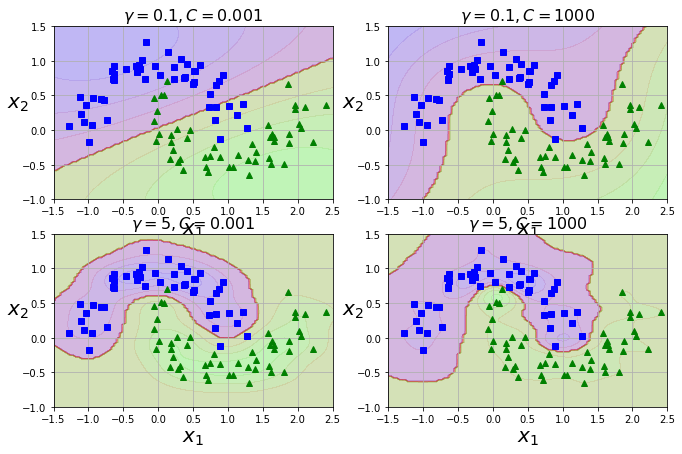

In [8]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

위 그래프들은 하이퍼파라미터 `gamma` ($\gamma$)와 `C`를 바꾸어서 훈련시킨 모델입니다. 

- gamma를 증가시키면 종 모양 그래프가 좁아져서 각 샘플의 영향 범위가 작아집니다. 결정 경계가 조금 더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어집니다.
- 반대로 작은 gamma값은 넓은 종 모양 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워집니다.

결국 하이퍼파라미터 $\gamma$가 규제의 역할을 합니다. 모델이 과대적합일 경우엔 감소시켜야하고 과소적합일 경우엔 증가시켜야합니다. 

다른 커널도 있지만 거의 사용되지 않습니다. 여러가지 커널 중 가장 먼저 선형 커널을 시도해봐야합니다. (`LinearSVC`가 `SVC(kernel='linear')`보다 훨씬 빠르다는 것을 기억하세요!) 특히 훈련 세트가 아주 크거나 특성 수가 많을 경우에 그렇습니다. 훈련 세트가 너무 크지 않다면 가우시안 RBF 커널을 시도해보면 좋습니다. 대부분의 경우 이 커널이 잘 들어맞습니다. 시간과 컴퓨팅 성능이 충분하다면 교차검증과 그리드 탐색을 통해 다른 커널을 좀 더 시도해볼 수 있습니다.

### 2.4 계산 복잡도

`LinearSVC` 파이썬 클래스는 선형 SVM을 위한 최적화된 알고리즘을 구현한 liblinear 라이브러리를 기반으로 합니다. 이 라이브러리는 커널 트릭을 지원하지 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어납니다. 이 알고리즘의 훈련 시간 복잡도는 대략 $O(m \times n)$ 정도입니다. 

정밀도를 높이면 알고리즘의 수행 시간이 길어집니다. 이는 허용 오차 하이퍼 파라미터 $\epsilon$으로 조절합니다. (사이킷런에서는 매개변수 `tol` 입니다.) 대부분의 분류 문제는 허용 오차를 기본값으로 두면 잘 작동합니다.

SVC 커널 트릭 알고리즘을 구현한 libsvm 라이브러리를 기반으로 합니다. 훈련의 시간복잡도는 보통 $O(m^2 \times n)$과 $O(m^3 \times n)$ 사이입니다. 이것은 훈련 샘플 수가 커지면 엄청나게 느려진다는 것입니다. 복잡하지만 작거나 중간 규모의 훈련 세트에 이 알고리즘이 잘 맞습니다. 하지만 특성의 개수에는, 특히 **희소 특성**(sparse features, 각 샘플에 0이 아닌 특성이 몇개 없는 경우)인 경우에는 잘 확장됩니다. 이런 경우 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 평균 수에 거의 비례합니다.



|파이썬 클래스|시간 복잡도|외부 메모리 학습 지원| 스케일 조정의 필요성|커널 트릭|
|:---|:---|:---|:---|:---|
|`LinearSVC`|$O(m \times n)$|아니오|예|아니오|
|`SGDClassifier`|$O(m \times n)$|예|아니오|아니오|
|`SVC`|$O(m^2 \times n) ~ O(m^3 \times n)$|아니오|예|예|

## 3. SVM 회귀

앞서 이야기한 것처럼 SVM 알고리즘은 다목적으로 사용할 수 있습니다. 선형, 비선형 분류 뿐만 아니라 선형, 비선형 회귀에도 사용할 수 있습니다. 회귀에 적용하는 방법은 목표를 반대로 하는 것입니다. 일정한 마진 오류 안에서 두 클래스 간의 도로 폭이 가능한 한 최대가 되도록 하는 대신, SVM 회귀는 제한된 마진 오류 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습합니다. 도로의 폭은 하이퍼 파라미터 $\epsilon$으로 조절합니다. 아래 그림은 무작위로 생성한 선형 데이터셋에 훈련시킨 두개의 선형 SVM 모델을 보여줍니다. 하나는 마진을 크게($\epsilon = 1.5$) 하고, 다른 하나는 마진을 작게($\epsilon = 0.5$)로 하여 만들었습니다.


마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없습니다. 그래서 이 모델을 **$\epsilon$에 민감하지 않다**고 말합니다.


사이킷런의 `LinearSVR`을 이용해 선형 SVM 회귀를 적용해보겠습니다. 다음 코드는 왼쪽 그래프에 해당하는 모델을 만듭니다.

In [9]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [10]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [11]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

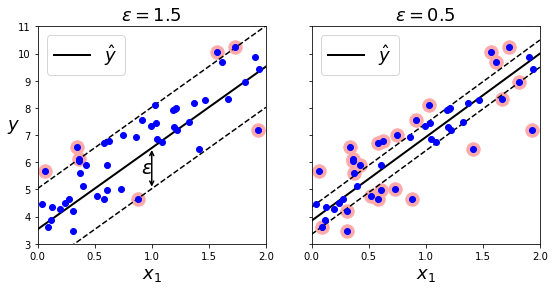

In [12]:
def plot_svm_regression(svm_reg, X, y, axes):
    xls = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(xls)
    plt.plot(xls, y_pred, "k-", linewidth = 2, label=r"$\hat{y}$")
    plt.plot(xls, y_pred + svm_reg.epsilon, "k--")
    plt.plot(xls, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors="#FFAAAA")
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc='upper left', fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey = True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
    '', xy=(eps_x1, eps_y_pred), xycoords = 'data',
    xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
    textcoords = 'data', arrowprops = {'arrowstyle' : "<->", 'linewidth' : 1.5}
)
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

비선형 회귀 작업을 처리하려면 커널 SVM 모델을 사용합니다. 예를 들어 아래 그림은 임의의 2차 방정식 형태의 훈련 세트에 2차 다항 커널을 사용한 SVM 회귀를 보여줍니다. 왼쪽 그래프는 규제가 거의 없고, (즉, 아주 큰 C) 오른쪽 그래프는 규제가 훨씬 많습니다. (즉, 작은 C)

비선형 회귀 작업은 사이킷런의 `SVR`을 이용해 만들 수 있습니다. `SVR`은 `SVC`의 회귀 버전이고, `LinearSVR`은 `LinearSVC`의 회귀 버전입니다. `LinearSVR`은 (`LinearSVC`처럼) 필요한 시간이 훈련 세트의 크기에 비럐해서 선형적으로 늘어납니다. 하지만 `SVR`은 (`SVC`처럼) 훈련 세트가 커지면 훨씬 느려집니다.

In [13]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel='poly', gamma='auto', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

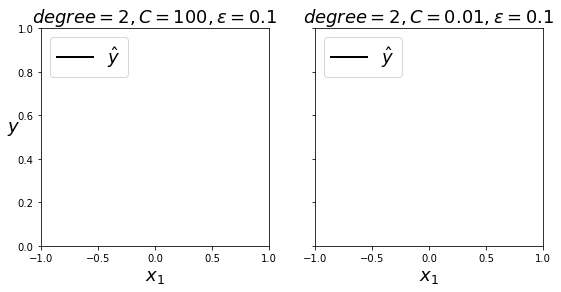

In [15]:
svm_poly_reg1 = SVR(kernel='poly', degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg2 = SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1, gamma='scale')
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

### 요약 정리하기!! 

> SVM, 서포트 벡터 머신 : 가장 폭이 넓은 도로를 찾는 것 (=라지 마진 분류)

- 서포트 벡터 : 도로 경계에 위치한 샘플
- 마진 분류의 종류
    - 하드 마진 분류 : 모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있는 것. 이상치에서 취약하다.
    - 소프트 마진 분류 : 이상치에 대한 적절한 균형. `C` 하이퍼 파라미터를 통해 균형을 조절할 수 있다.
        - 큰 `C` : 마진 오류를 적게 함, 도로 폭도 같이 좁아짐
        - 작은 `C` : 마진 오류가 크게 남. 도로 폭은 넓어짐.
- 힌지 손실
- 비선형 `SVM` 분류도 가능하다. 
    - `PolynomialFeatures`와 `StandardScaler`, `LinearSVC` 연결해서 사용하기
- **커널 트릭** : SVM에서 실제 특성을 추가하지 않으면서 다항식에 특성을 많이 추가한것과 같은 효과.
    - `SVC(kernel = 'poly', degree=2, coef0 = 1, C=5)`와 같이 사용
    - 모델이 과대적합 -> 다항식의 차수를 줄임. / 모델이 과소적합 -> 모델의 차수를 늘림
    - `coef0` : 모델이높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절
- 유사도 특성 추가하기
    - 각 샘플이 특정 랜드마트와 얼마나 닮았는지
    - 유사도 함수 : 가우시한 방사 기저 함수 (RBF)
- 계산 복잡도
    - LinearSVC : 일반적으로 좋은 성능. 커널 트릭을 지원하진 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어난다. 
    - SVC : 훈련 샘플 수가 커지면 엄청나게 느려진다. 희소 특성인 경우에는 잘 들어맞는다. 
- 회귀
    - SVC -> SVR
    - `LinearSVR`, `SVR` 이런 식으로 사용한다. 

In [16]:
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:90% !important;}</style>"))